In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import sys
import glob

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from PIL import Image
import nibabel as nib

from scipy import stats
import math


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import SimpleITK as sitk
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

from random import choice

2023-03-09 15:34:41.466163: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#define folder
date = '20_10_22'


In [3]:
#load metafile
meta = pd.read_csv('/csc/epitkane/home/atagmazi/AD_DL_ADNI/metafile_completing/metafile_completed_adni_all_04_10_2022.csv')

In [4]:
meta.shape

(31431, 27)

In [5]:
# delete damaged file
meta = meta.loc[meta['Image_id'] != 'I280713']
meta = meta.loc[meta['Image_id'] != 'I1217088']

In [6]:
meta.shape

(31429, 27)

In [7]:
meta

,Unnamed: 0.1,Unnamed: 0,Image_id,RID,Subject.ID,Project,Phase,Sex,Weight,Research.Group,...,Modality,pipeline,Description,pet_tracer,csf_method,ABETA,TAU,PTAU,CLASS,PATH
0,1,6,I45107,295,002_S_0295,ADNI,ADNI 1,M,74.5,CN,...,MRI,MPR; GradWarp; B1 Correction; N3,MP-RAGE,NaN,NaN,NaN,NaN,NaN,NaN,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_00...
1,9,18,I40965,295,002_S_0295,ADNI,ADNI 1,M,74.1,CN,...,MRI,MPR; GradWarp; B1 Correction; N3,MP-RAGE,NaN,NaN,NaN,NaN,NaN,NaN,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_00...
2,15,24,I64023,295,002_S_0295,ADNI,ADNI 1,M,72.6,CN,...,MRI,MPR; GradWarp; B1 Correction; N3,MP-RAGE,NaN,Elecsys,858.3,399.5,39.29,3.0,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_00...
3,20,37,I123684,295,002_S_0295,ADNI,ADNI 1,M,73.8,CN,...,MRI,MPR; GradWarp; B1 Correction; N3,MP-RAGE,NaN,NaN,NaN,NaN,NaN,NaN,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_00...
4,25,42,I150176,295,002_S_0295,ADNI,ADNI 1,M,72.9,CN,...,MRI,MPR; GradWarp; B1 Correction; N3,MP-RAGE,NaN,Elecsys,708.6,381.3,38.72,3.0,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_00...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31426,68816,85355,I1480672,6962,941_S_6962,ADNI,ADNI 3,F,48.1,AD,...,PET,"FDG Co-registered, Averaged",PET Brain DYNAMIC 6x5MIN FDG,FDG,NaN,NaN,NaN,NaN,NaN,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_94...
31427,68818,85357,I1482710,6962,941_S_6962,ADNI,ADNI 3,F,48.1,AD,...,PET,"AV1451 Coreg, Avg, Standardized Image and Voxe...",PET Brain DYNAMIC 6x5MIN Tau,AV1451,NaN,NaN,NaN,NaN,NaN,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_94...
31428,68820,85359,I1482712,6962,941_S_6962,ADNI,ADNI 3,F,48.1,AD,...,PET,"AV1451 Co-registered, Averaged",PET Brain DYNAMIC 6x5MIN Tau,AV1451,NaN,NaN,NaN,NaN,NaN,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_94...
31429,68822,85361,I1507283,6998,941_S_6998,ADNI,ADNI 3,M,68.0,CN,...,PET,"FBB Coreg, Avg, Standardized Image and Voxel Size",PET Brain - DYNAMIC 4X5MIN FBB,FBB,NaN,NaN,NaN,NaN,NaN,/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_94...


In [8]:
# use only abeta scans
meta_csf = meta[meta['ABETA'].notna()]

In [9]:
meta_csf.shape

(9749, 27)

In [10]:
meta_abeta = meta_csf.loc[meta_csf['pet_tracer'].isin(['AV45','FBB','PIB'])]

In [11]:
meta_abeta = meta_abeta[meta_abeta['pipeline'].str.contains('Coreg, Avg, Standardized Image and Voxel Size', regex=False)]

In [12]:
meta_abeta.shape

(1870, 27)

In [14]:
print(meta_abeta)

       Unnamed: 0.1  Unnamed: 0  Image_id   RID  Subject.ID Project    Phase  \
11               40          58   I240520   295  002_S_0295    ADNI   ADNI 2   
70              224         336   I187802   685  002_S_0685    ADNI  ADNI GO   
80              240         352   I323916   685  002_S_0685    ADNI   ADNI 2   
98              302         449   I190159   729  002_S_0729    ADNI  ADNI GO   
103             308         455   I324215   729  002_S_0729    ADNI   ADNI 2   
...             ...         ...       ...   ...         ...     ...      ...   
31371         68698       85237  I1049561  6546  941_S_6546    ADNI   ADNI 3   
31375         68706       85245  I1049565  6570  941_S_6570    ADNI   ADNI 3   
31379         68714       85253  I1078477  6574  941_S_6574    ADNI   ADNI 3   
31395         68746       85285  I1081303  6580  941_S_6580    ADNI   ADNI 3   
31403         68762       85301  I1051997  6581  941_S_6581    ADNI   ADNI 3   

      Sex  Weight Research.Group  ...  

In [17]:
# permutation !!!
abeta_perm = meta_abeta.sample(frac=1)


In [20]:
abeta_perm.value_counts('Research.Group')

Research.Group
CN      607
EMCI    449
LMCI    259
MCI     220
AD      190
SMC     145
dtype: int64

In [85]:
#split data on train and test subsets
train_size = 0.8
train_end = int(len(abeta_perm)*train_size)

In [88]:
#save permutated metafile if needed
#abeta_perm =  pd.read_csv(date+'/abeta_info_'+date+'.csv')

In [89]:
print(train_end)

1496


In [90]:
abeta_train = abeta_perm[:train_end]
abeta_test = abeta_perm[train_end:]

In [94]:
# creat dictionaries with info for generator
abeta_partition = dict()
abeta_labels = dict()
#abeta_all = dict()

t = int(0.8*np.shape(abeta_train)[0]) #!!
v = int(0.2*np.shape(abeta_train)[0]) 
#DATADIR = r"/csc/epitkane/data/ADNI/AD_DL_03_11_2021/"


abeta_partition['train'] = abeta_perm.iloc[:t,-1].tolist() 
abeta_partition['validation'] = abeta_perm.iloc[t:train_end,-1].tolist()
abeta_partition['test'] = abeta_perm.iloc[train_end:,-1].tolist() 

abeta_partition['all'] = abeta_perm.iloc[:,-1].tolist() 
#print(abeta_partition['train'])


In [97]:
len(abeta_partition['all'])

1870

In [24]:
len(abeta_partition['train'])

1196

In [25]:
len(abeta_partition['train'])*12

14352

In [39]:
#check NA
any(np.isnan(val) for val in abeta_train['ABETA'])

False

In [98]:
index = 0
for img in abeta_perm['PATH']:
    #print(img)
    
    abeta_labels[img] = np.log(abeta_perm.reset_index(drop=True).loc[index,'ABETA'])
    index +=1

In [99]:
np.log(640.3)

6.461936816524757

In [100]:
abeta_labels

{'/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_073_S_4777_PT_AV45_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20120803192349604_51_S159438_I321667.nii': 7.217550221931332,
 '/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_137_S_4631_PT_AV45_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20120622185554117_30_S153757_I312065.nii': 6.49664837818128,
 '/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_036_S_4538_PT_AV45_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20120524084254146_62_S150972_I306226.nii': 6.352402772602529,
 '/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_130_S_5175_PT_AV45_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20150616100807473_36_S262112_I497675.nii': 7.710653323501202,
 '/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_016_S_5251_PT_AV45_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20131024073818270_18_S204429_I395766.nii': 6.222718095484271,
 '/csc/epitkane/data/ADNI/AD_DL_16_04_22/ADNI_041_S_4138_PT_AV45_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_2013100

In [101]:
#example of image
start = time.time()
img = nib.load('/csc/epitkane/data/ADNI/AD_DL_03_11_2021/ADNI_128_S_0188_PT_PIB_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20100622134348255_53_S87355_I179844.nii')
end = time.time()
print(end - start)

0.026941537857055664


In [102]:
np.shape(img)

(160, 160, 96, 1)

In [103]:
image2 = img.get_fdata()
print(type(image2))
np.shape(image2)

<class 'numpy.memmap'>


(160, 160, 96, 1)

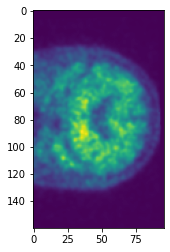

In [51]:
plt.imshow(image2[:,100,:,0])


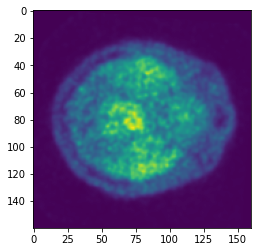

In [59]:
plt.imshow(image2[:,:,25,0])

In [104]:
# augmentation function
def aug_random(scan):
    # add different level of noise
    def aug_noise0(scan):
        t1_noise = add_gaussian_noise(scan.copy(), sigma=0)
        return t1_noise
    def aug_noise5(scan):
        t1_noise = add_gaussian_noise(scan.copy(), sigma=0.05)
        return t1_noise
    def aug_noise10(scan):
        t1_noise = add_gaussian_noise(scan.copy(), sigma=0.1)
        return t1_noise
    def aug_noise15(scan):
        t1_noise = add_gaussian_noise(scan.copy(), sigma=0.15)
        return t1_noise
    def aug_noise20(scan):
        t1_noise = add_gaussian_noise(scan.copy(), sigma=0.2)
        return t1_noise
    def aug_noise25(scan):
        t1_noise = add_gaussian_noise(scan.copy(), sigma=0.25)
        return t1_noise
    # flip an image
    def aug_flipx(scan):# 0 - flip by x axis, 1 - y axis,2 - by z, but it's seems useless
        t1_flip = flip(scan.copy(), axis=0)
        return t1_flip
    def aug_flipy(scan):
        t1_flip = flip(scan.copy(), axis=1)
        return t1_flip
    fns = [aug_noise0,aug_noise5,aug_noise10,aug_noise15,aug_noise20,aug_noise25,aug_flipx,aug_flipy]
    return choice(fns)(scan)

In [105]:
# data generator
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, mode_train=True, batch_size=32, dim=(512,512), shuffle=True,
                 n_channels = 3):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        #self.n_classes = n_classes
        self.shuffle = shuffle
        self.mode_train = mode_train
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp): #~!!!!!
        
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=float) #!!!!
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img=nib.load(ID)
            image =  np.asarray(img.get_fdata())
            if self.mode_train == True:
                image = aug_random(image)
            #X[i,] = np.divide(image, 255) #?
            X[i,] = image
            # Store class
            y[i] = self.labels[ID]
            

        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

In [106]:
params = {'dim': (160,160,96),
          'batch_size': 4,
          #'n_classes': 4,
          'n_channels': 1,
          'shuffle': False}



# Generators
abeta_training_generator = DataGenerator(abeta_partition['train']*12, abeta_labels,mode_train=True, **params)
abeta_validation_generator = DataGenerator(abeta_partition['validation'], abeta_labels, mode_train=False, **params)
abeta_all_generator = DataGenerator(abeta_partition['all'], abeta_labels,mode_train=False, **params)


In [124]:
len(abeta_perm)*12/8

2805.0

In [107]:
# IMPORT test set 
abeta_test_x_or = []
abeta_test_label = []
index = 0
#DATADIR = r"/csc/epitkane/data/ADNI/AD_DL_03_11_2021/"

for img in abeta_test.iloc[:,-1]: #!!
    imag=nib.load(img)
    image = imag.get_fdata()
    abeta_test_x_or.append(image)

abeta_test_x = np.asarray(abeta_test_x_or)


In [108]:
abeta_test_label = np.log(abeta_test.iloc[:,-5].values)

abeta_test_label = abeta_test_label.reshape((abeta_test_label.shape[0],1))




In [45]:
abeta_test_x.shape

(374, 160, 160, 96, 1)

In [88]:
print(type(abeta_test_label))
print(abeta_test_label.dtype)

<class 'numpy.ndarray'>
float64


In [45]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = keras.layers.Conv3D(filters=F1, kernel_size=(1, 1,1), strides=(1, 1,1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization( name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv3D(filters=F2, kernel_size=(f, f,f), strides=(1, 1,1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization( name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv3D(filters=F3, kernel_size=(1, 1,1), strides=(1, 1,1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization( name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])# SKIP Connection
    X = keras.layers.Activation('relu')(X)

    return X

In [46]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv3D(filters=F1, kernel_size=(1, 1,1), strides=(s, s,s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization( name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv3D(filters=F2, kernel_size=(f, f,f), strides=(1, 1,1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization( name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv3D(filters=F3, kernel_size=(1, 1,1), strides=(1, 1,1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization( name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv3D(filters=F3, kernel_size=(1, 1,1), strides=(s, s,s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization( name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X

In [47]:
# ArcheD model architecture
def ResNet(input_shape=(160,160,96,1)):

    X_input = keras.Input(input_shape)


    X = keras.layers.Conv3D(64, (7, 7,3), strides=(2, 2,2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = keras.layers.BatchNormalization( name='bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling3D((3, 3,3), strides=(2, 2,2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)

    
    X = keras.layers.MaxPooling3D(pool_size=(2, 2,2), padding='same')(X)


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)



    X = keras.layers.MaxPooling3D(pool_size=(2, 2,2), padding='same')(X)
    X = keras.layers.Flatten()(X)
    X=keras.layers.Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)

    X=keras.layers.Dense(32, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.Dense( 1, activation='linear', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet')

    return model



In [48]:
# model_abeta = ArcheD model
model_abeta = ResNet(input_shape=(160,160,96,1))

In [49]:
model_abeta.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 96 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 77, 77, 47, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 77, 77, 47, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 77, 77, 47, 6 0           bn_conv1[0][0]                   
_____________________________________________________________________________________________

In [42]:
len(model_abeta.layers)

35

In [138]:
model_abeta.compile(loss= 'mse',optimizer= keras.optimizers.Adam(lr=0.0001),metrics=['mse','mae'])

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = keras.callbacks.ModelCheckpoint(date+'/model_{epoch:02d}-{val_loss:.2f}_'+date+'.h5', monitor='val_loss', mode='min', save_best_only=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [94]:

history = model_abeta.fit_generator(generator=abeta_training_generator,
                                    validation_data=abeta_validation_generator, epochs=150, 
                                    callbacks=[es, mc,reduce_lr],
                                    verbose=1) 


In [ ]:
# save model
model_abeta.save(date+'/abeta_cnn_'+date+'.h5') #!!

In [ ]:
# evaluate model on test data
test_acc = model_abeta.evaluate(abeta_test_x, abeta_test_label, verbose=0, batch_size = 4) #!!
print(test_acc)

In [ ]:
# predict test 
ynew2= model_abeta.predict(abeta_test_x, batch_size = 4) #!!


In [ ]:
#predict train
yold2 =  model_abeta.predict(abeta_training_generator)



In [ ]:

stat = stats.linregress(abeta_test_label.flatten(), ynew2.flatten()) # slope intersept rvalue pvalue stderr intercept_stderr
print(stat)
print(stat[3])
print(stat[2]**2)


In [ ]:
# save files
np.save(date+'/abeta_history_'+date+'.npy',history.history)
np.save(date+'/abeta_stat_'+date+'.npy',stat)
np.save(date+'/abeta_test_acc_'+date+'.npy',test_acc)
np.save(date+'/abeta_prediction_'+date+'.npy',ynew2)
np.save(date+'/abeta_train_prediction_'+date+'.npy',yold2)
np.save(date+'/abeta_testlab_'+date+'.npy',abeta_test_label)
abeta_perm.to_csv(date+'/abeta_info_'+date+'.csv')


In [ ]:
print('1st part saved')

In [ ]:
#predict all
yall =  model_abeta.predict(abeta_all_generator)
 



In [ ]:
np.save(date+'/abeta_all_prediction_'+date+'.npy',yall)

In [ ]:
#print('the end')
#sys.exit()

In [109]:
# model for dense layer output extraction
model2 = keras.Model(model_abeta.input, model_abeta.layers[-2].output)

NameError: name 'model_abeta' is not defined

In [110]:
model2.compile(loss= 'mse',optimizer= keras.optimizers.Adam(lr=0.0001), #check the learning rate
               metrics=['mse','mae'])

NameError: name 'model2' is not defined

In [53]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_input (InputLayer)    [(None, 160, 160, 96, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 158, 158, 94, 8)   224       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 52, 31, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 50, 50, 29, 8)     1736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 16, 9, 8)      0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                117971

In [71]:
dense = model2.predict(abeta_training_generator)

In [ ]:
np.save(date+'/abeta_dense_out_'+date+'.npy',dense)

In [ ]:
dense_all = model2.predict(abeta_all_generator)

In [ ]:
np.save(date+'/abeta_dense_all_out_'+date+'.npy',dense_all)

In [ ]:
# BEST MODEL by validation loss
# in case we saved model from each epoch we first need to identify the best one by validation lost

In [126]:
hist=np.load(date+'/abeta_history_'+date+'.npy',allow_pickle='TRUE').item()

In [127]:
hist['val_loss']

[0.9034926295280457,
 0.2063860297203064,
 0.15910622477531433,
 0.17502473294734955,
 0.13335280120372772,
 0.13246940076351166,
 0.16599689424037933,
 0.12361481040716171,
 0.13889099657535553,
 0.13170093297958374,
 0.13778942823410034,
 0.12977942824363708,
 0.13153661787509918,
 0.129241481423378,
 0.12836560606956482,
 0.12592819333076477,
 0.126034215092659,
 0.12687534093856812,
 0.12658947706222534,
 0.12651196122169495,
 0.1264016479253769,
 0.1254587173461914,
 0.12651775777339935]

In [128]:
best_model_number = np.where(hist['val_loss']==np.min(hist['val_loss']))[0].tolist()[0]
np.where(hist['val_loss']==np.min(hist['val_loss']))[0].astype(int)[0]

print(glob.glob(date+'/*')[best_model_number])
best_model_name = glob.glob(date+'/*')[best_model_number]
saved_model = keras.models.load_model( best_model_name)

In [65]:
#saved_model = keras.models.load_model(date+'/best_model_'+date+'.h5')

2022-08-18 09:39:16.878072: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-18 09:39:16.879991: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-18 09:39:16.880039: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 09:39:16.880100: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a0): /proc/driver/nvidia/version does not exist
2022-08-18 09:39:16.880477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wit

In [133]:
saved_model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 96 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 77, 77, 47, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 77, 77, 47, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 77, 77, 47, 6 0           bn_conv1[0][0]                   
_____________________________________________________________________________________________

In [134]:
test_acc_best = saved_model.evaluate(abeta_test_x, abeta_test_label, verbose=0, batch_size = 4) #!!
print(test_acc_best)#

2022-10-24 10:45:35.074953: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3676569600 exceeds 10% of free system memory.


KeyboardInterrupt: 

# Evaluation of the best model

In [119]:
ynew2_best= saved_model.predict(abeta_test_x, batch_size = 4) #!!


2022-10-19 15:14:09.552788: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3676569600 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [ ]:
yold2_best =  saved_model.predict(abeta_training_generator)


In [ ]:
yall_best =  saved_model.predict(abeta_all_generator)


In [ ]:
stat_best = stats.linregress(abeta_test_label.flatten(), ynew2_best.flatten()) # slope intersept rvalue pvalue stderr intercept_stderr

In [ ]:
# save files
np.save(date+'/abeta_stat_best_'+date+'.npy',stat_best)
np.save(date+'/abeta_test_acc_best_'+date+'.npy',test_acc_best)
np.save(date+'/abeta_prediction_best_'+date+'.npy',ynew2_best)
np.save(date+'/abeta_train_prediction_best_'+date+'.npy',yold2_best)
np.save(date+'/abeta_all_prediction_best_'+date+'.npy',yall_best)


In [16]:
model3 = keras.Model(saved_model.input, saved_model.layers[-2].output)

In [ ]:
dense_best = model3.predict(abeta_training_generator)

In [ ]:
np.save(date+'/abeta_dense_out_best_'+date+'.npy',dense_best)

In [ ]:
dense_all_best = model3.predict(abeta_all_generator)

In [ ]:
np.save(date+'/abeta_dense_all_out_best_'+date+'.npy',dense_all_best)

In [ ]:
print('DONE')

Epoch 1/10
